In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import joblib

In [4]:
# OPTION 1 : Chargement du dataset par reps

data_raw = pd.read_csv("data/rep_dataset.csv")

data_raw = data_raw.drop(['id', 'total_frames', 'frame_number', 'width', 'height'], axis=1)
data_raw = data_raw[data_raw['rep'] != -1]

C:\Users\Arthur\AppData\Local\Temp\ipykernel_18784\455991005.py:3: DtypeWarning: Columns (124) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv("data/rep_dataset.csv")


In [10]:
# OPTION 2 : Chargement du dataset complet

data_raw = pd.read_csv("data/full_landmarks_dataset_features3.csv")

data_raw = data_raw.drop(['total_frames', 'frame_number', 'width', 'height'], axis=1)

In [12]:
# OPTION 2 bis : Chargement du dataset complet pour les 4 classes principales seulement

data_raw = data_raw[data_raw['label'].isin(['push-up', 'leg extension', 'barbell biceps curl', 'squat'])]

In [13]:
# PCA

# data_numbers = data_raw.drop(['rep', 'video_name', 'label'], axis=1).to_numpy() # OPTION 1
data_numbers = data_raw.drop(['video_name', 'label'], axis=1).to_numpy()  # OPTION 2
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_numbers)
pca_df = pd.DataFrame(data = pca_result, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

# Rajouter les labels, les reps et les video_names dans pca_df
# pca_df['rep'] = data_raw['rep'].values # OPTION 1
pca_df['label'] = data_raw['label'].values
pca_df['video_name'] = data_raw['video_name'].values

# Label encoding
le = LabelEncoder()
pca_df['label'] = le.fit_transform(pca_df['label'])

In [8]:
# OPTION 1 : Découpage du dataset en répétitions

SEQ_LEN = 10   # à ajuster selon tes données

X_list = []
y_list = []

for (video, rep_id), group in pca_df.groupby(['video_name', 'rep']): # Instruction à bien retenir
    
    group = group.sort_index()  # sécurité temporelle
    features = group[['pca1', 'pca2', 'pca3']].values
    label = group['label'].iloc[0]
    
    # Echantillonage des séquences
    if len(features) >= SEQ_LEN:
        # On sélectionne SEQ_LEN frames uniformément réparties
        indices = np.linspace(0, len(features) - 1, SEQ_LEN).astype(int)
        features = features[indices]
    else:
        pad = np.zeros((SEQ_LEN - len(features), 3))
        features = np.vstack([features, pad])
    
    # Flatten pour le MLP
    features = features.flatten()
    
    X_list.append(features)
    y_list.append(label)
    
# Split train/test

groups = []
for (video, rep_id), _ in pca_df.groupby(['video_name', 'rep']):
    groups.append(video)
groups = np.array(groups)

KeyError: 'rep'

In [14]:
# OPTION 2 : Découpage du dataset en vidéos complètes

SEQ_LEN = 10   # à ajuster selon tes données

X_list = []
y_list = []

for (video, group) in pca_df.groupby(['video_name']): # Instruction à bien retenir
    
    group = group.sort_index()  # sécurité temporelle
    features = group[['pca1', 'pca2', 'pca3']].values
    label = group['label'].iloc[0]
    
    # Echantillonage des séquences
    if len(features) >= SEQ_LEN:
        # On sélectionne SEQ_LEN frames uniformément réparties
        indices = np.linspace(0, len(features) - 1, SEQ_LEN).astype(int)
        features = features[indices]
    else:
        pad = np.zeros((SEQ_LEN - len(features), 3))
        features = np.vstack([features, pad])
    
    # Flatten pour le MLP
    features = features.flatten()
    
    X_list.append(features)
    y_list.append(label)
    
# Split train/test

groups = []
for (video, group) in pca_df.groupby(['video_name']):
    groups.append(video)
groups = np.array(groups)

In [15]:
# Conversion en tableaux numpy
X = np.array(X_list)
y = np.array(y_list)

# Conversion en tenseurs PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)


# X contient les features, y les labels

In [16]:
# Split par groupes (vidéos)
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X[train_idx]
X_test  = X[test_idx]
y_train = y[train_idx]
y_test  = y[test_idx]

print("Nb vidéos train :", len(np.unique(groups[train_idx])))
print("Nb vidéos test  :", len(np.unique(groups[test_idx])))

Nb vidéos train : 108
Nb vidéos test  : 27


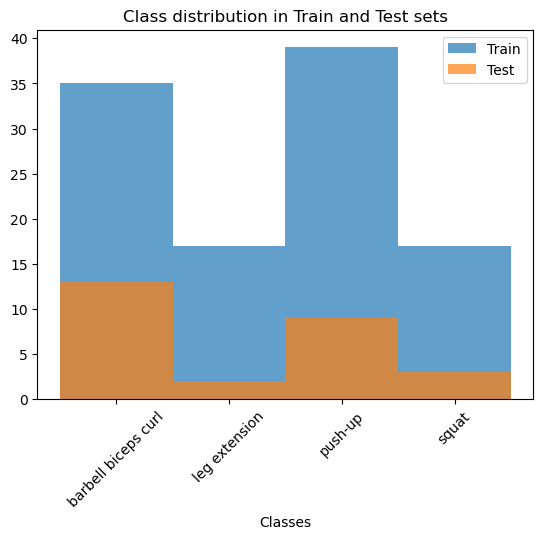

In [17]:
# Répartition des classes dans train et test

train_labels, train_counts = np.unique(y_train.numpy(), return_counts=True)
test_labels, test_counts = np.unique(y_test.numpy(), return_counts=True)

plt.Figure(figsize=(12,5))
plt.hist(train_labels, bins=np.arange(len(le.classes_)+1)-0.5, weights=train_counts, alpha=0.7, label='Train')
plt.hist(test_labels, bins=np.arange(len(le.classes_)+1)-0.5, weights=test_counts, alpha=0.7, label='Test')
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=45)
plt.xlabel('Classes')
plt.legend()
plt.title('Class distribution in Train and Test sets')
plt.show()

In [18]:
# Reshape pour CNN 1D
# Avant : X_train.shape = (N, SEQ_LEN*3)
# Après : (N, 3, SEQ_LEN)

X_train = X_train.view(X_train.shape[0], SEQ_LEN, 3).permute(0, 2, 1)
X_test  = X_test.view(X_test.shape[0],  SEQ_LEN, 3).permute(0, 2, 1)


In [19]:
# Définition des modèles

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class CNN1D(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # SEQ_LEN = 10
        # Après 2 pool /2 : 10 → 5 → 2
        self.fc1 = nn.Linear(64 * 2, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [20]:
# Entrainement et évaluation du modèle

# model = MLP(input_size=30, hidden_size=100, num_classes=4) # OPTION 1
# model = MLP(input_size=30, hidden_size=100, num_classes=22) # OPTION 2
# model = MLP(input_size=30, hidden_size=100, num_classes=4) # OPTION 2 bis
model = CNN1D(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrainement

model.train()
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 5.4466
Epoch [2/50], Loss: 3.2802
Epoch [3/50], Loss: 2.0097
Epoch [4/50], Loss: 1.3640
Epoch [5/50], Loss: 0.9100
Epoch [6/50], Loss: 0.9344
Epoch [7/50], Loss: 0.7333
Epoch [8/50], Loss: 0.5646
Epoch [9/50], Loss: 0.4951
Epoch [10/50], Loss: 0.5124
Epoch [11/50], Loss: 0.5415
Epoch [12/50], Loss: 0.5234
Epoch [13/50], Loss: 0.4393
Epoch [14/50], Loss: 0.3751
Epoch [15/50], Loss: 0.4581
Epoch [16/50], Loss: 0.2490
Epoch [17/50], Loss: 0.2752
Epoch [18/50], Loss: 0.2440
Epoch [19/50], Loss: 0.2647
Epoch [20/50], Loss: 0.1980
Epoch [21/50], Loss: 0.2595
Epoch [22/50], Loss: 0.2062
Epoch [23/50], Loss: 0.1550
Epoch [24/50], Loss: 0.2359
Epoch [25/50], Loss: 0.2289
Epoch [26/50], Loss: 0.1939
Epoch [27/50], Loss: 0.1626
Epoch [28/50], Loss: 0.1429
Epoch [29/50], Loss: 0.1823
Epoch [30/50], Loss: 0.1254
Epoch [31/50], Loss: 0.1235
Epoch [32/50], Loss: 0.1499
Epoch [33/50], Loss: 0.1346
Epoch [34/50], Loss: 0.1479
Epoch [35/50], Loss: 0.1469
Epoch [36/50], Loss: 0.1209
E

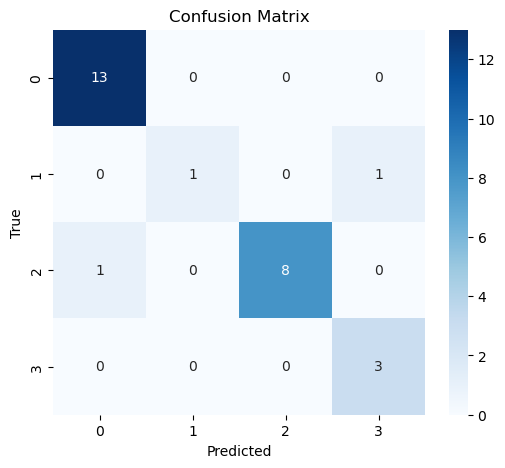

              precision    recall  f1-score   support

           0     0.9286    1.0000    0.9630        13
           1     1.0000    0.5000    0.6667         2
           2     1.0000    0.8889    0.9412         9
           3     0.7500    1.0000    0.8571         3

    accuracy                         0.9259        27
   macro avg     0.9196    0.8472    0.8570        27
weighted avg     0.9378    0.9259    0.9220        27



In [21]:
# Prédictions
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, y_pred = torch.max(outputs, 1)

# Matrice de confusion
cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Rapport détaillé
print(classification_report(
    y_test.cpu().numpy(),
    y_pred.cpu().numpy(),
    digits=4
))


In [ ]:
# Pour finir, sauvegarde du modèle et de la PCA

torch.save(model.state_dict(), "models/cnn_model.pth")
joblib.dump(pca, "models/pca.pkl")
